In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from skimage.io import imread
import cv2
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
images = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

print(images[0])

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png


In [ ]:
print(len(images))

277524


In [ ]:
df = pd.DataFrame(index = np.arange(0,len(images)),columns = ["path","target"])

for i in range (0,len(images)):
    df.iloc[i]["path"] = images[i]
    df.iloc[i]["target"] = int(images[i][-5])

df

,path,target
0,/kaggle/input/breast-histopathology-images/IDC...,0
1,/kaggle/input/breast-histopathology-images/IDC...,0
2,/kaggle/input/breast-histopathology-images/IDC...,0
3,/kaggle/input/breast-histopathology-images/IDC...,0
4,/kaggle/input/breast-histopathology-images/IDC...,0
...,...,...
277519,/kaggle/input/breast-histopathology-images/IDC...,1
277520,/kaggle/input/breast-histopathology-images/IDC...,1
277521,/kaggle/input/breast-histopathology-images/IDC...,1
277522,/kaggle/input/breast-histopathology-images/IDC...,1


In [ ]:
df.head()

,path,target
0,/kaggle/input/breast-histopathology-images/IDC...,0
1,/kaggle/input/breast-histopathology-images/IDC...,0
2,/kaggle/input/breast-histopathology-images/IDC...,0
3,/kaggle/input/breast-histopathology-images/IDC...,0
4,/kaggle/input/breast-histopathology-images/IDC...,0


In [ ]:
df[df.target==1].count()

path      78786
target    78786
dtype: int64

In [ ]:
df.shape

(277524, 2)

In [ ]:
pos = np.random.choice(df[df.target==1].index.values, size=40, replace=False)
neg = np.random.choice(df[df.target==0].index.values, size=40, replace=False)

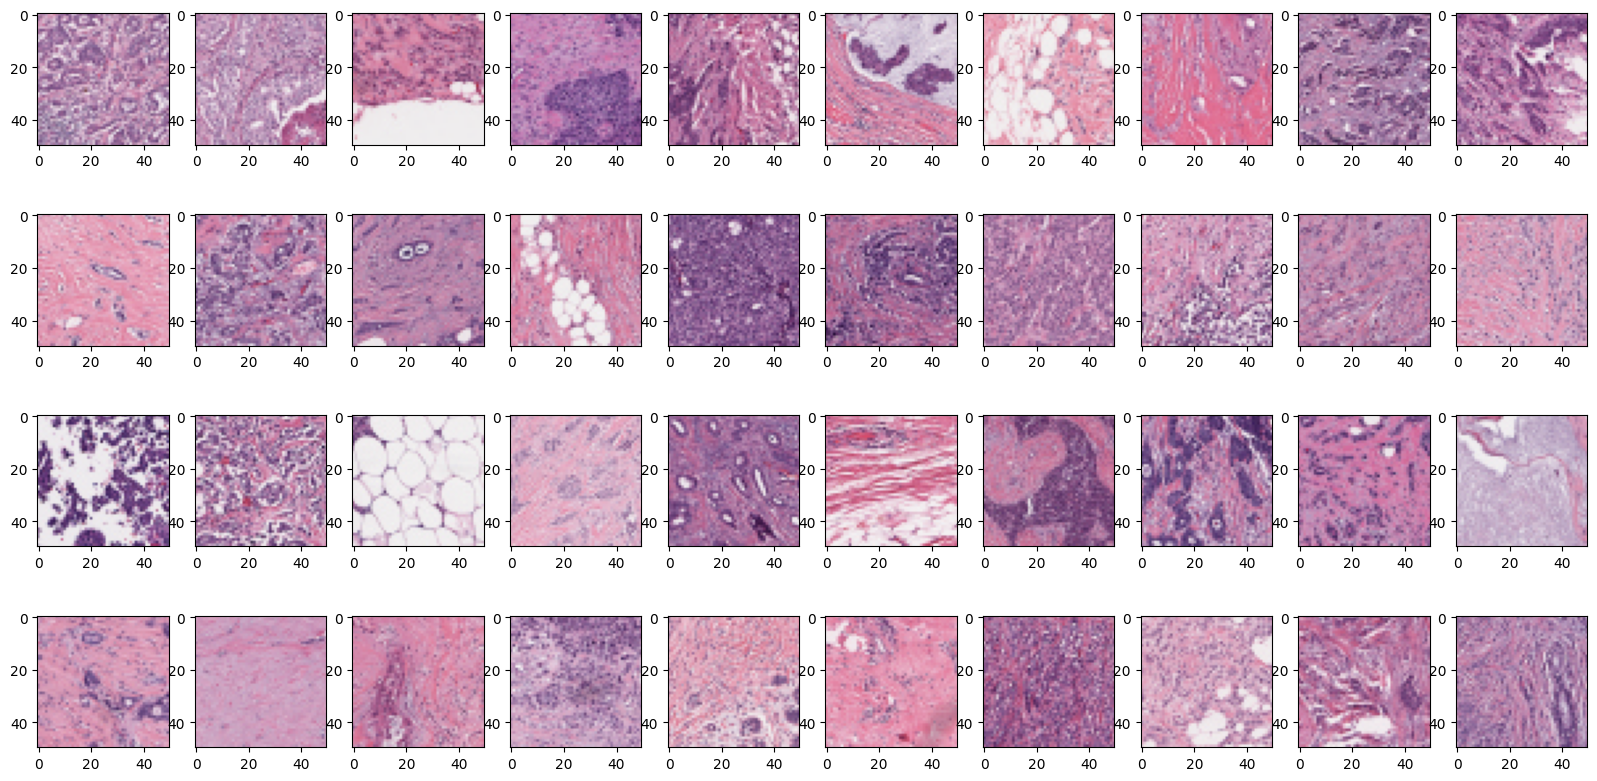

In [ ]:
fig, ax = plt.subplots(4,10,figsize=(20,10))

for i in range(4):
    for j in range(10):
        idx = pos[j + 10*i]
        image = imread(df.loc[idx, "path"])
        ax[i,j].imshow(image)

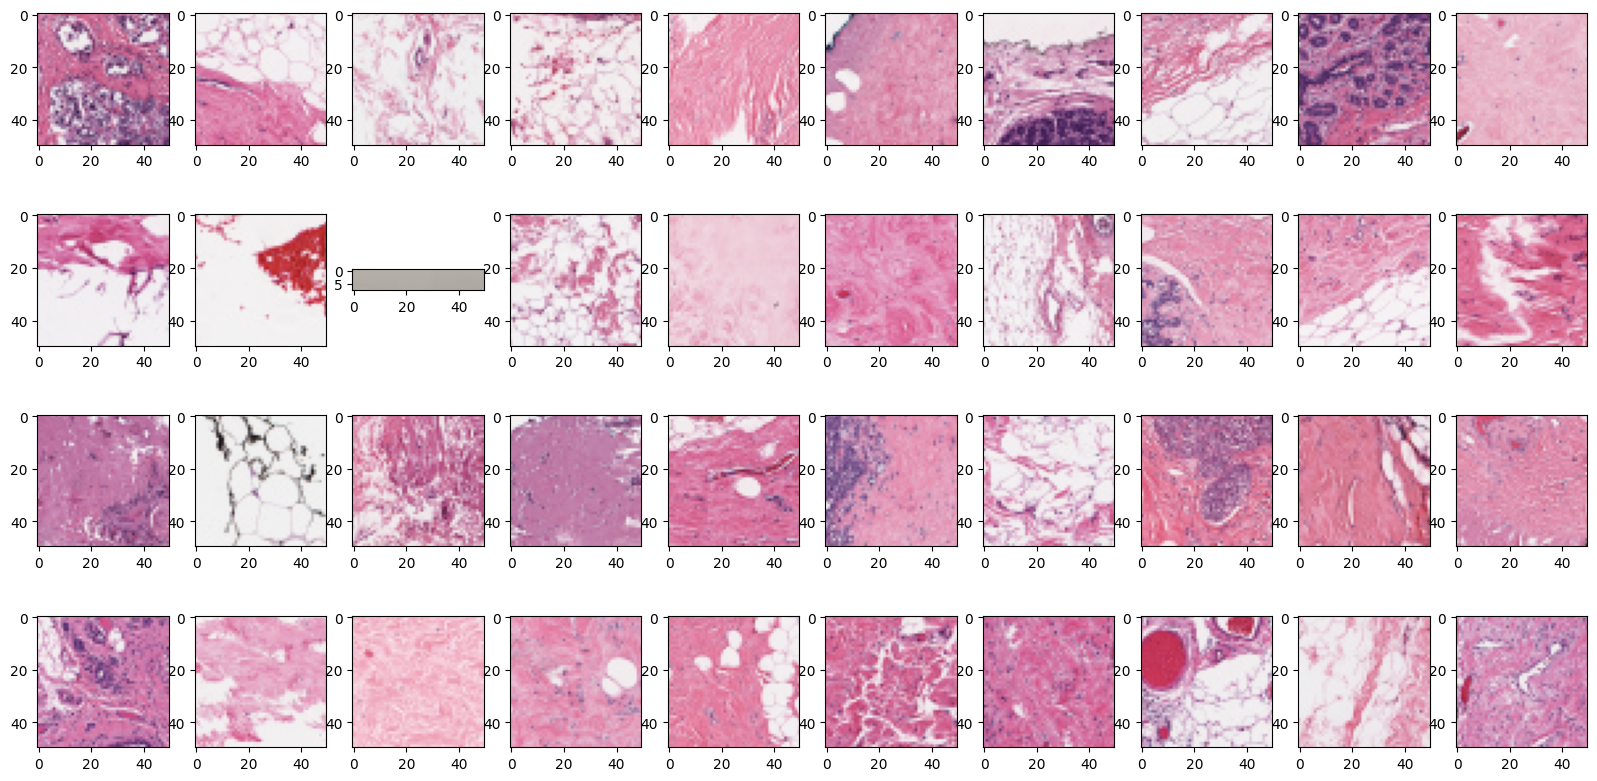

In [ ]:
fig, ax = plt.subplots(4,10,figsize=(20,10))

for i in range(4):
    for j in range(10):
        idx = neg[j + 10*i]
        image = imread(df.loc[idx, "path"])
        ax[i,j].imshow(image)


In [ ]:
all_images = df.values
np.random.shuffle(all_images)

In [ ]:
len(all_images)

277524

In [ ]:
X = []
y = []
for f,l in all_images:
    image = cv2.imread(f,cv2.IMREAD_COLOR)
    image = cv2.resize(image, (50, 50), interpolation = cv2.INTER_LINEAR)
    X.append(image)
    y.append(l)
X = np.array(X)
y = np.array(y)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42,shuffle = True)

In [ ]:
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.utils import to_categorical

2024-07-20 14:09:33.670932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 14:09:33.671032: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 14:09:33.826989: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)

In [ ]:
early_stop=EarlyStopping(monitor='val_loss',patience=5)
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs = 20 , batch_size = 35)

Epoch 1/20
   7/5075 ━━━━━━━━━━━━━━━━━━━━ 1:52 22ms/step - accuracy: 0.4626 - loss: 1.2039

I0000 00:00:1721484604.459960      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1721484604.492037      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5075/5075 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8397 - loss: 0.3752

W0000 00:00:1721484683.619050      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5075/5075 ━━━━━━━━━━━━━━━━━━━━ 102s 17ms/step - accuracy: 0.8397 - loss: 0.3752 - val_accuracy: 0.8244 - val_loss: 0.3720
Epoch 2/20
5075/5075 ━━━━━━━━━━━━━━━━━━━━ 121s 15ms/step - accuracy: 0.8690 - loss: 0.3130 - val_accuracy: 0.8131 - val_loss: 0.4191
Epoch 3/20
5075/5075 ━━━━━━━━━━━━━━━━━━━━ 76s 15ms/step - accuracy: 0.8762 - loss: 0.2926 - val_accuracy: 0.8848 - val_loss: 0.2905
Epoch 4/20
5075/5075 ━━━━━━━━━━━━━━━━━━━━ 76s 15ms/step - accuracy: 0.8808 - loss: 0.2819 - val_accuracy: 0.7233 - val_loss: 0.5232
Epoch 5/20
5075/5075 ━━━━━━━━━━━━━━━━━━━━ 76s 15ms/step - accuracy: 0.8862 - loss: 0.2713 - val_accuracy: 0.8634 - val_loss: 0.3064
Epoch 6/20
5075/5075 ━━━━━━━━━━━━━━━━━━━━ 76s 15ms/step - accuracy: 0.8893 - loss: 0.2632 - val_accuracy: 0.8806 - val_loss: 0.3020
Epoch 7/20
5075/5075 ━━━━━━━━━━━━━━━━━━━━ 76s 15ms/step - accuracy: 0.8944 - loss: 0.2540 - val_accuracy: 0.8405 - val_loss: 0.3732
Epoch 8/20
5075/5075 ━━━━━━━━━━━━━━━━━━━━ 76s 15ms/step - accuracy: 0.8971 - loss: 0.

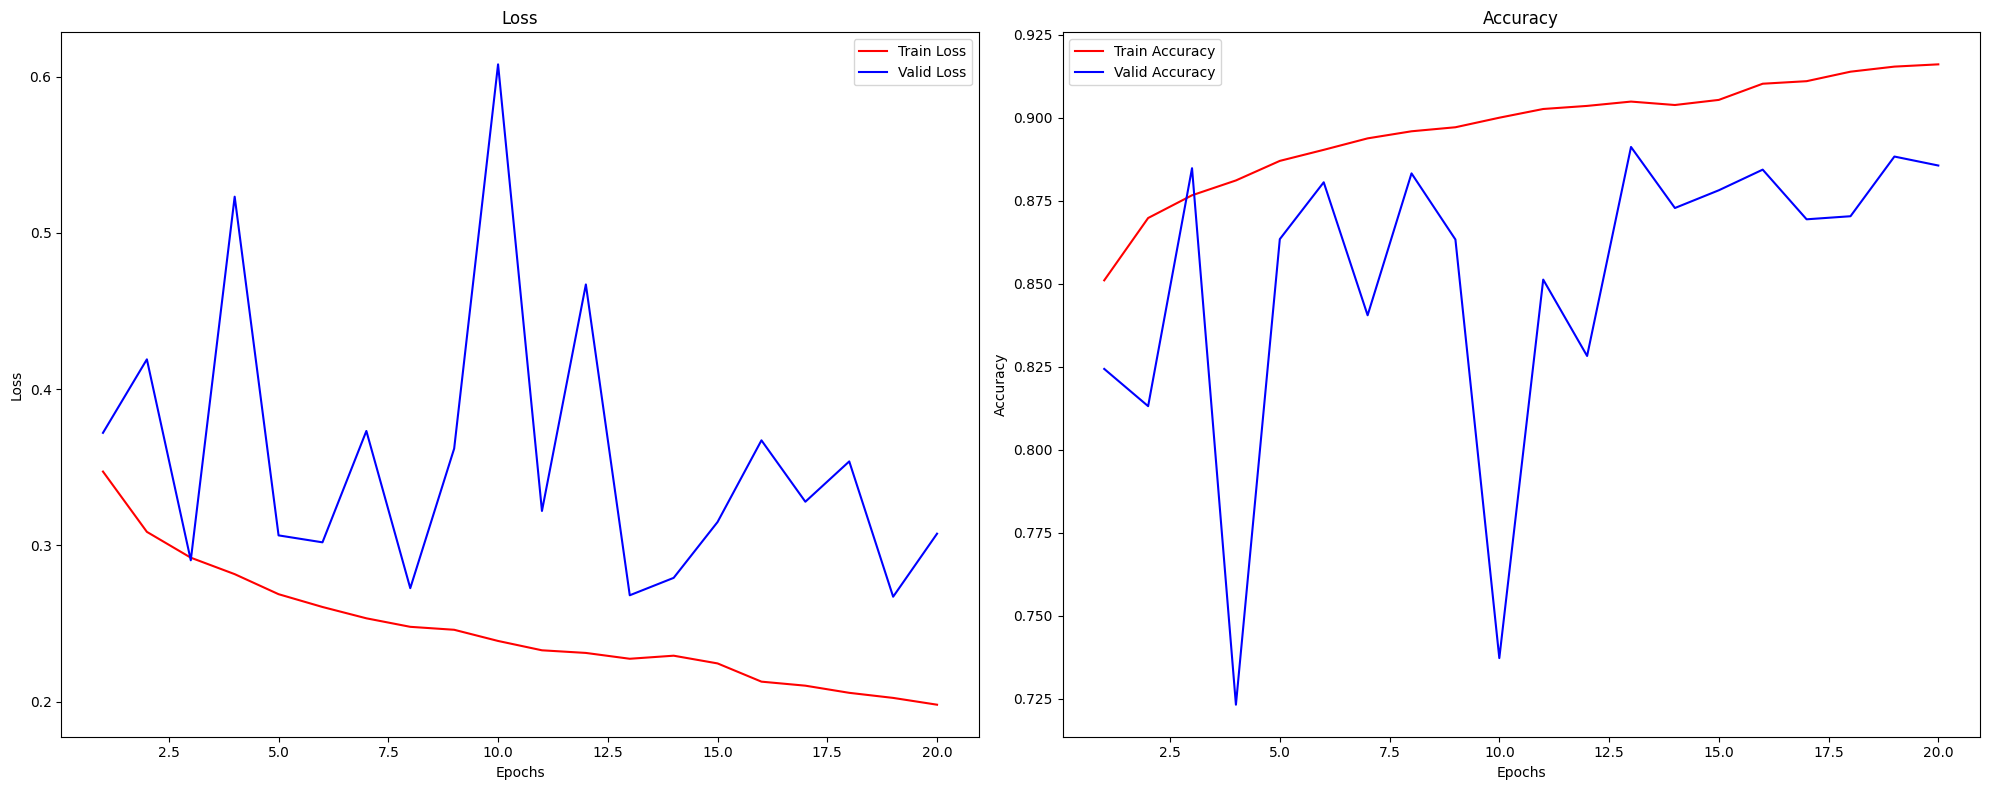

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'b', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.delete(y_pred, 0, axis=1)
y_pred =(y_pred > 0.5)

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


In [ ]:
y_test1 = np.delete(y_test, 0, axis=1)
cm = confusion_matrix(y_test1, y_pred)
cm

array([[35581,  4321],
       [ 2046, 13557]])

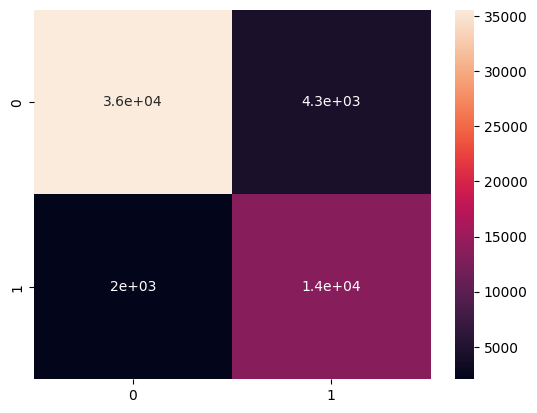

In [ ]:
sns.heatmap(cm, annot=True)
plt.show()

In [ ]:
loss,accuracy = model.evaluate(X_test,y_test)
print("Test Accuracy:", accuracy)
print("Loss:", loss)

1735/1735 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8836 - loss: 0.3282
Test Accuracy: 0.8852896094322205
Loss: 0.3192308247089386
